### Notes

#### Minnesota is simply the best.  Their site has fantastic data going back over a decade, pre-merged to shapefiles.  Their links continue to work.  Other states' data should be like Minnesota's.

* Clearinghouse: https://www.gis.leg.mn/html/download.html
* ftp://ftp.commissions.leg.state.mn.us/pub/gis/shape/elec2016.zip
* ftp://ftp.commissions.leg.state.mn.us/pub/gis/shape/elec2012.zip
* ftp://ftp.commissions.leg.state.mn.us/pub/gis/shape/elec08.zip

In [1]:
import sys; sys.path.insert(0,'../')
from dist_tools import *

import pandas as pd
import geopandas as gpd
from IPython.display import display

import psycopg2
from netrc import netrc
from fiona.crs import from_epsg

user, acct, passwd = netrc().authenticators("harris")

seats, fips, epsg = 8, 27, 3594

%matplotlib inline
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000

In [2]:
mnf = "/media/jsaxon/brobdingnag/data/el_dv/mn_site/"
map_08 = gpd.read_file(mnf + "elec2008.shp")
map_08.rename(columns = {"USPRESDFL" : "D08", "USPRESR" : "R08"}, inplace = True)
map_08 = map_08[["D08", "R08", "geometry"]]
map_08["DFrac"] = map_08.D08 / (map_08.D08 + map_08.R08)
map_08 = map_08.to_crs(epsg = epsg)

map_12 = gpd.read_file(mnf + "elec2012.shp")
map_12.rename(columns = {"USPRSDFL" : "D12", "USPRSR" : "R12"}, inplace = True)
map_12 = map_12[["D12", "R12", "geometry"]]
map_12["DFrac"] = map_12.D12 / (map_12.D12 + map_12.R12)
map_12 = map_12.to_crs(epsg = epsg)

map_16 = gpd.read_file(mnf + "elec2016.shp")
map_16.rename(columns = {"USPRSDFL" : "D16", "USPRSR" : "R16"}, inplace = True)
map_16 = map_16[["D16", "R16", "geometry"]]
map_16["DFrac"] = map_16.D16 / (map_16.D16 + map_16.R16)
map_16 = map_16.to_crs(epsg = epsg)

In [3]:
output_geojson(map_08.set_geometry(map_08.geometry.simplify(10)), var = "DFrac", fname = "mapped/mn_2008.geojson")
output_geojson(map_12.set_geometry(map_12.geometry.simplify(10)), var = "DFrac", fname = "mapped/mn_2012.geojson")
output_geojson(map_16.set_geometry(map_16.geometry.simplify(10)), var = "DFrac", fname = "mapped/mn_2016.geojson")

In [4]:
tr_rn = get_tr_rn("mn").to_crs(epsg = epsg)

In [5]:
votes08 = merge_tract_number(tr_rn, map_08)[["D08", "R08"]]
votes12 = merge_tract_number(tr_rn, map_12)[["D12", "R12"]]
votes16 = merge_tract_number(tr_rn, map_16)[["D16", "R16"]]

In [6]:
pd.concat([votes08, votes12, votes16], axis = 1).astype(int).to_csv("votes/mn.csv")

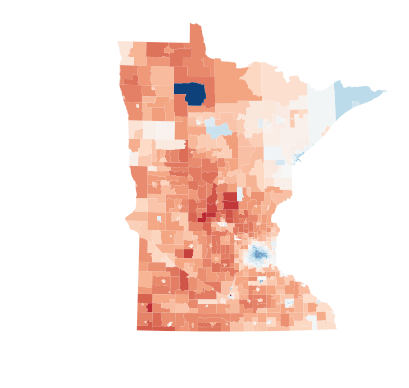

In [7]:
map_sanity_check("mn", 2016, epsg)